# Από τους Νευρώνες στα Ρούχα

Προσαρμοσμένο από την [τεκμηρίωση του TensorFlow](https://www.tensorflow.org/tutorials/keras/classification).

---

> Πάνος Λουρίδας, Αναπληρωτής Καθηγητής <br />
> Τμήμα Διοικητικής Επιστήμης και Τεχνολογίας <br />
> Οικονομικό Πανεπιστήμιο Αθηνών <br />
> louridas@aueb.gr

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import optimizers

tf.random.set_seed(0)

* Η πρώτη μας πραγματική εφαρμογή με νευρωνικά δίκτυα θα είναι η ταξινόμηση στο σύνολο δεδομένων [MNIST](https://github.com/zalandoresearch/fashion-mnist).

* Περιέχει 70.000 γκριζόασπρες εικόνες που ανήκουν σε 10 κατηγορίες ιματισμού.

* Η κάθε φωτογραφία είναι 28x28 pixels.

* Τα δεδομένα είναι διαθέσιμα από το TensorFlow.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

* Οι ετικέτες είναι τα ονόματα των κλάσεων.

| Label	| Class |
|-------|-------|
|   0   | T-shirt/top |
|   1   | Trouser |
|   2   | Pullover |
|   3   | Dress |
|   4   | Coat |
|   5   | Sandal |
|   6   | Shirt |
|   7   | Sneaker |
|   8   | Bag |
|   9   | Ankle boot |


* Θα αποθηκεύσουμε τα ονόματα των κλάσεων σε μία λίστα για να τα έχουμε διαθέσιμα στη συνέχεια.

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

* Τα δεδομένα εκμάθησης είναι 60.000 εικόνες, κάθε μία διαστάσεων 28x28 pixels.

* Υπάρχουν επίσης 60.000 ετικέτες, η κάθε μία από 0 έως και το 9.

In [4]:
print(train_images.shape)
print(len(train_labels))
print(train_labels)

(60000, 28, 28)
60000
[9 0 0 ... 3 0 5]


* Τα δεδομένα ελέγχου αποτελούνται από 10.000 εικόνες, κάθε μία 28x28 pixels.

* Και, φυσικά, 10.000 ετικέτες.

In [5]:
print(test_images.shape)
print(len(test_labels))

(10000, 28, 28)
10000


* Ας δούμε μια εικόνα.

* Οι τιμές στα pixels μπορούν να κυμαίνονται από το 0 έως και το 255.

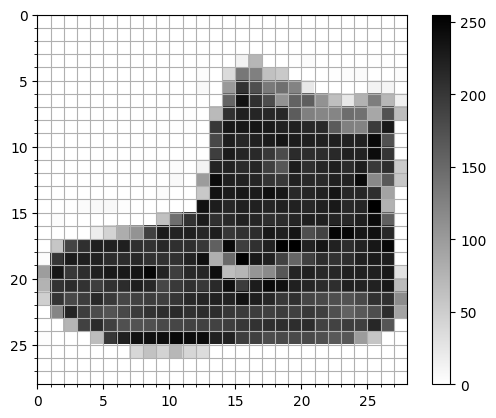

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.margins(0, 0)  
plt.imshow(train_images[0], 
           extent=(0, train_images[0].shape[0], train_images[0].shape[1], 0),
           cmap=plt.cm.binary)
plt.colorbar()
plt.xlim(0, 28)
plt.ylim(28, 0)
minor_ticks = np.arange(0, 28, 1)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')

* Στα νευρωνικά δίκτυα επίσης δεν αρέσουν τα δεδομένα με μεγάλες διακυμάνσεις, οπότε θα τα μετατρέψουμε ώστε να έχουν τιμές μεταξύ 0 και 1.

In [7]:
train_images = train_images / 255.0

test_images = test_images / 255.0

* Για να δούμε τις πρώτες 25 φωτογραφίες.

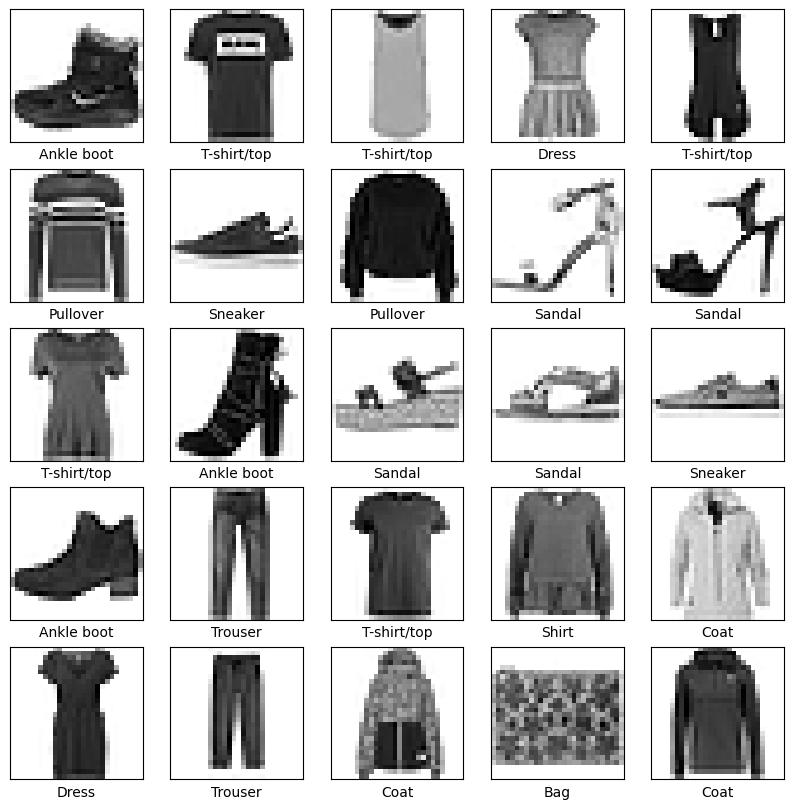

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

* Θα χρησιμοποιήσουμε μια νέα συνάρτηση ενεργοποίησης, τον *ανορθωτή* (rectifier):
$$ f(x)=x^{+}=\max(0,x)$$

* Ένας νευρώνας, ή *μονάδα* (unit) που χρησιμοποιεί τον ανορθωτή ονομάζεται *ανορθωμένη γραμμική μονάδα*, rectified linear unit, ή απλώς ReLU.

* Κάποιες φορές χρησιμοποιούμε μια ομαλή προσέγγιση του , τη συνάρτηση *softplus*:
$$f(x)=\log(1+ e^{x})$$

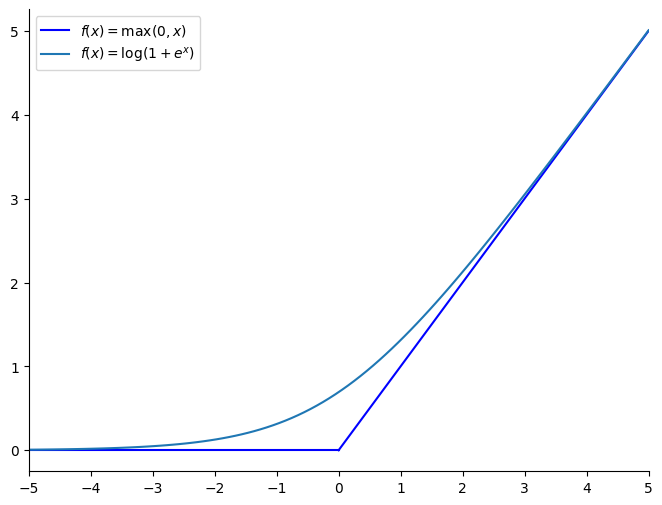

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim((-5, 5))
plt.xticks(np.arange(-5, 6, 1))
x = np.linspace(-5, 0, 50)
y = np.zeros_like(x)
plt.plot(x, y, color='blue')
x = np.linspace(0, 5, 50)
y = x
relu, = plt.plot(x, y, color='blue', label=r"$f(x) = \max(0, x)$")
x = np.linspace(-5, 5, 100)
y = np.log(1 + np.exp(x))
softplus, = plt.plot(x, y, label=r"$f(x) = \log(1 + e^{x})$")
plt.legend(handles=[relu, softplus], loc='best')

* Τώρα ας στήσουμε το μοντέλο μας.

* Θα αποτελείται από τρία στρώματα.

* Το πρώτο στρώμα μετά την είσοδο θα μετατρέψει την είσοδο από πίνακες 28x28 σε μονοδιάστατους πίνακες των 784 pixels.

* Το δεύτερο στρώμα θα είναι πυκνά συνδεμένο. Θα έχει 128 κόμβους (νευρώνες), που θα είναι ReLU.

* Το τρίτο στρώμα θα είναι πάλι πυκνά συνδεμένο και δεν θα έχει συνάρτηση ενεργοποίησης. 

* Άρα η ενεργοποίηση θα είναι γραμμική, $a(x) = x$, και ο νευρώνας θα δίνει απλώς τη σταθμισμένη είσοδο συν την πόλωση.

In [10]:
model = keras.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10)
])

* Με τη μέθοδο `summary()` μπορούμε να δούμε σε μορφή πίνακα το δίκτυο.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

* Εναλλακτικά, μπορούμε να το δούμε με γραφικό τρόπο.

* Η είσοδος στο πρώτο στρώμα και στο στρώμα `Flatten` είναι τρισδιάστατη. Αυτό συμβαίνει επειδή τα δεδομένα έρχονται σε φουρνιές, αλλά το μέγεθος της φουρνιάς θα γίνει γνωστό κατά την εκτέλεση, οπότε εμφανίζεται ως `None`.

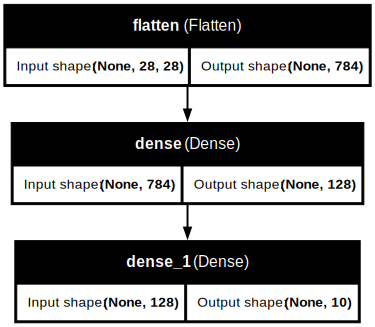

In [12]:
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

* Μπορούμε να επιβεβαιώσουμε τον αριθμό των παραμέτρων: 

  * $784 \times 128 = 100.352$ βάρη μεταξύ του στρώματος `Flatten` και του επόμενου στρώματος.
  
  * $128 \times 10 = 1280$ βάρη μεταξύ του κρυφού στρώματος και του στρώματος εξόδου.
  
  * $128$ πολώσεις στο κρυφό στρώμα.
  
  * $10$ πολώσεις στο στρώμα εξόδου.
  
  * Σύνολο: $100.352 + 1280 + 128 + 10 = 101.770$

In [13]:
model.count_params()

101770

* Τώρα μπορούμε να προχωρήσουμε στον ορισμό:

  * Της συνάρτησης απώλειας.
  * Του βελτιστοποιητή.
  * Της μετρικής αξιολόγησης.

* Θέλουμε η συνάρτηση απώλειας να υπολογίζει το λάθος στην έξοδο του δικτύου.

* Αλλά τι ακριβώς είναι η έξοδος;

* Είναι ένα διάνυσμα με 10 αριθμούς, έναν για κάθε νευρώνα στο στρώμα εξόδου.

* Κάθε ένας από αυτούς του αριθμούς δίνει την πεποίθηση του δικτύου ότι το δείγμα στην είσοδο ανήκει στη συγκεκριμένη κλάση.

In [14]:
# As we have not trained the model yet, these are random values.
predictions = model(train_images[:1]).numpy()
print(predictions)
print('min =', np.min(predictions), 
      'max =', np.max(predictions), 
      'sum =', np.sum(predictions))

[[ 0.2983152  -0.75367785 -0.9145873  -0.7334101  -0.640675    0.01275733
   0.26590532  0.7823298  -0.12656197 -0.507551  ]]
min = -0.9145873 max = 0.7823298 sum = -2.3171554


* Οι στόχοι μας είναι επίσης διανύσματα με 10 αριθμούς, π.χ. αν το ρούχο είναι μποτάκι:

  ```[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]```

* Κάθε ένα από αυτά τα διανύσματα έχει μία τιμή ίση με 1 (η σωστή κλάση), ενώ οι άλλες τιμές είναι ίσες με 0.

* Αυτό σημαίνει ότι κάθε στόχος είναι στην πραγματικότητα μια κατανομή πιθανοτήτων, αφού είναι ένα σύνολο τιμών από το μηδέν έως το ένα που αθροίζουν στο ένα.

* Άρα θέλουμε να μετατρέψουμε την έξοδο του δικτύου σε μία κατανομή πιθανοτήτων.

* Θα είναι ένα διάνυσμα με δέκα τιμές, κάθε μία μεταξύ μηδέν και ένα, που θα αθροίζουν στο ένα.

* Όμως αυτή τη στιγμή η έξοδος του δικτύου δεν είναι μια τέτοια κατανομή.

* Είναι απλώς η έξοδος των νευρώνων του τελεταίου στρώματος, οι οποίοι μάλιστα δεν έχουν συνάρτηση ενεργοποίησης, άρα απλώς ένας γραμμικός συνδυασμών των εισόδων.

* Οι προβλέψεις του μοντέλου σε αυτή τη μορφή ονομάζονται *logits*.

* Για να μετατρέψουμε τα logits σε μια κατανομή πιθανοτήτων χρησιμοποιούμε τη συνάρτηση *softmax*.

* Αν έχουμε $K$ κλάσεις, και ο $k$ νευρώνας έχει έξοδο $z_k$, η συνάρτηση softmax ορίζεται ως:
$$\sigma(z_{j}) = {\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}\, , j = 1, 2, \ldots, k$$

* Στην ουσία, η softmax δίνει τις εισόδους στην εκθετική συνάρτηση και κανονικοποιεί.

* Η εκθετική συνάρτηση σημαίνει ότι μια μονάδα αύξηση στην είσοδο έχει πολλαπλασιαστικά αποτελέσματα στην έξοδο.

* Αντιστρόφως, αν μειώνεται η είσοδος, στην έξοδο παίρνουμε κλάσμα της εισόδου.

* Η softmax διαιρεί με το άθροισμα της εκθετικής συνάρτησης στις εισόδους, ώστε το αποτελέσμα να είναι μεταξύ και ένα.

In [15]:
softmax_predictions = tf.nn.softmax(predictions).numpy()
print(softmax_predictions)
print('min =', np.min(softmax_predictions), 
      'max =', np.max(softmax_predictions), 
      'sum =', np.sum(softmax_predictions))

[[0.14626686 0.05108238 0.04348997 0.05212827 0.05719363 0.10993341
  0.14160234 0.23732899 0.09563659 0.06533752]]
min = 0.04348997 max = 0.23732899 sum = 1.0


* Στο TensorFlow, ορίζουμε ότι θα χρησιμοποιήσουμε το αποτέλεσμα της softmax στον υπολογισμό της απώλειας δίνοντας την παράμετρο `from_logits=True`.

* Η δε συνάρτηση απώλειας που θα χρησιμοποιήσουμε υλοποιείται στην κλάση  `SparseCategoricalCrossEntropy`, άρα θα δώσουμε `SparseCategoricalCrossEntropy(from_logits=True)`.

* Θα ορίσουμε τον βελτιστοποιητή, αυτή τη φορά έναν άλλο, τον Adam optimizer (Adaptive Moment Estimation).

* Δίνουμε την απώλεια όπως εξηγήσαμε παραπάνω, και τη μετρική της απόδοσης.

In [16]:
model.compile(
    optimizer=optimizers.Adam(), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

* Προχωράμε στην εκπαίδευση.

* Θα αφήσουμε το `batch_size` στην προεπιλεγμένη τιμή, δηλαδή 32.

* Κάθε εποχή θα έχει $60.000 / 32 = 1875$ φουρνιές.

In [17]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7821 - loss: 0.6317
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8606 - loss: 0.3843
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8757 - loss: 0.3383
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8860 - loss: 0.3116
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8936 - loss: 0.2920


* Θα ελέγξουμε την επίδοση του συστήματος με τα δεδομένα ελέγχου.

* Αυτά θα διαβαστούν σε $\lceil1000 / 32\rceil = 313$ φουρνιές.

In [18]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8777 - loss: 0.3519
Test accuracy: 0.8708999752998352


* Τα αποτελέσματα είναι όπως τα περιμέναμε, με την έννοια ότι η ορθότητα είναι χαμηλότερη από αυτήν που είδαμε στην εκπαίδευση.

* Ουσιαστικά στην εκπαίδευση φτάσαμε σε υπερπροσαρμογή (overfitting).

* Μετά την εκπαίδευση, μπορούμε να χρησιμοποιήσουμε το δίκτυο για προβλέψεις.

* Πλην όμως, η έξοδος του δικτύου είναι logits.

* Θα τα μετατρέψουμε σε πιθανότητες.

* Για να το κάνουμε αυτό, παίρνουμε το αρχικό μας δίκτυο και του προσθέτουμε ένα στρώμα `SoftMax()`.

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


* Τώρα στη μεταβλητή `predictions` έχουμε τις προβλέψεις για τα δεδομένα ελέγχου.

* Για να δούμε την πρόβλεψη για την πρώτη εικόνα:

In [20]:
predictions[0]

array([4.06716254e-06, 2.41355139e-07, 1.79347353e-06, 5.06596294e-08,
       1.62855400e-07, 4.45077755e-03, 5.00822853e-06, 8.33746791e-03,
       1.19958195e-05, 9.87188399e-01], dtype=float32)

* Ή, σε ποσοστά:

In [21]:
for i in predictions[0]:
    print(f'{i:f}')

0.000004
0.000000
0.000002
0.000000
0.000000
0.004451
0.000005
0.008337
0.000012
0.987188


* Το σωστό ρούχο είναι το:

In [22]:
print(test_labels[0])

9


* Θα φτιάξουμε μια βοηθητική συνάρτητη η οποία θα μας δείχνει την πρόβλεψη και τον στόχο.

* Αν η πρόβλεψη συμπίπτει με τον στόχο, θα είναι μπλε. Διαφορετικά, θα είναι κόκκινη.

In [23]:
def plot_image(i, predictions, true_labels, img):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

* Θα φτιάξουμε και μια ακόμα βοηθητική συνάρτηση που θα μας εμφανίζει όλες τις πιθανότητες που δίνει το δίκτυο για κάθε εικόνα.

In [24]:
def plot_value_array(i, predictions, true_labels, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

* Ας δούμε τι παίρνουμε για την πρώτη εικόνα.

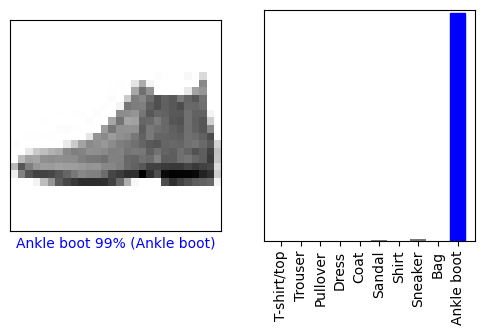

In [25]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions, test_labels, test_images)

plt.subplot(1,2,2)
plot_value_array(0, predictions, test_labels, True)

* Είναι ενδιαφέρον να δούμε τι συνέβη με τις εικόνες που έκανε λάθος το δίκτυο.

* Ας τις βρούμε.

In [26]:
predicted_labels = np.apply_along_axis(np.argmax, 1, predictions)
print('Predicted labels:', predicted_labels)
misclassified = test_labels != predicted_labels
print('Misclassified:', misclassified)
misclassified_indices = np.argwhere(misclassified)
print('Misclassified indices:\n', misclassified_indices)
print('Number of misclassified:', len(misclassified_indices))

Predicted labels: [9 2 1 ... 8 1 5]
Misclassified: [False False False ... False False False]
Misclassified indices:
 [[  25]
 [  29]
 [  40]
 ...
 [9977]
 [9979]
 [9989]]
Number of misclassified: 1291


* Στη συνέχεια, ας τις δούμε.

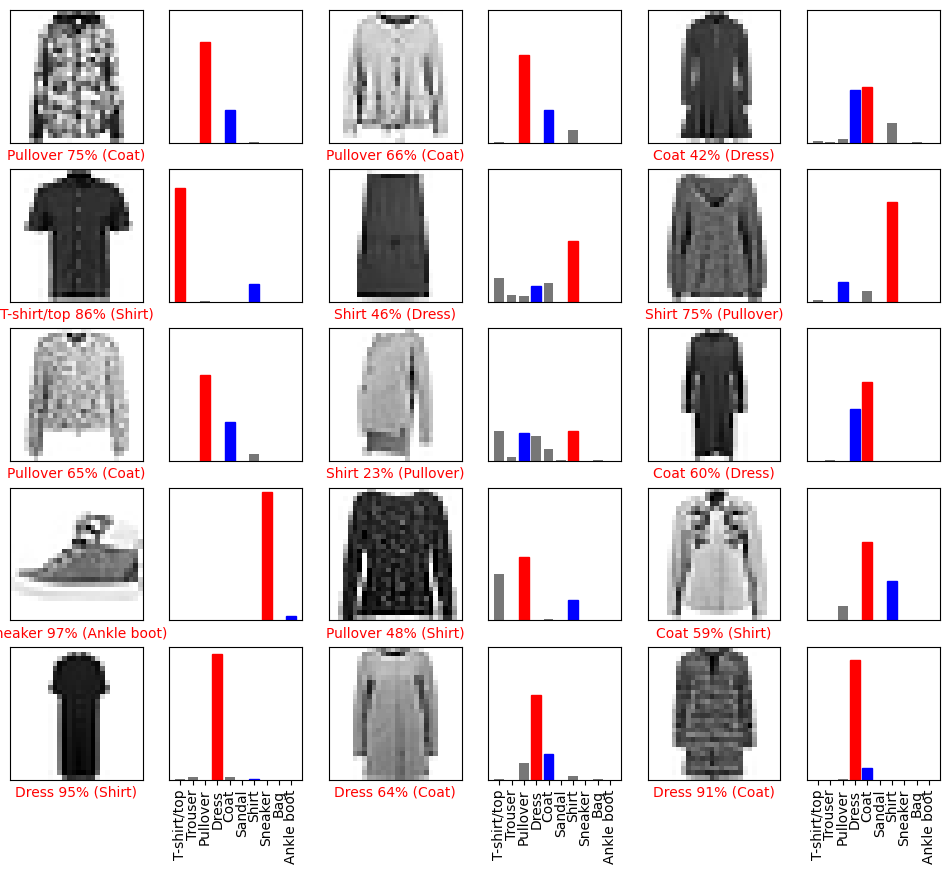

In [27]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

show_x_ticks = False
for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices[i-1][0], predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices[i-1][0], predictions,  test_labels, show_x_ticks)

* Όπως πάντα, μπορούμε να χρησιμοποιήσουμε την αναφορά ταξινόμησης.

* Αφού οι `predictions` είναι κατανομές πιθανοτήτων, παίρνουμε την κλάση της μέγιστης πιθανότητας με την `np.argmax()`.

In [28]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.96      0.98      0.97      1000
           2       0.77      0.78      0.78      1000
           3       0.85      0.90      0.87      1000
           4       0.71      0.86      0.78      1000
           5       0.98      0.93      0.95      1000
           6       0.81      0.55      0.66      1000
           7       0.94      0.94      0.94      1000
           8       0.97      0.95      0.96      1000
           9       0.92      0.97      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



* Και ο πίνακας σύγχισης:

In [29]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, np.argmax(predictions, axis=1)))

[[846  14  21  45  10   2  52   0  10   0]
 [  0 978   1  16   4   0   0   0   1   0]
 [ 13   3 783  16 145   0  39   0   1   0]
 [ 16  21  14 895  45   0   6   0   3   0]
 [  1   1  81  31 860   0  26   0   0   0]
 [  0   0   0   1   0 926   0  32   4  37]
 [149   7 106  45 133   0 552   0   8   0]
 [  0   0   0   0   0   9   0 944   1  46]
 [  6   0  14   5  11   3   4   5 952   0]
 [  0   0   0   0   0   1   1  25   0 973]]
